In [32]:
# Set the right working folder to root folder of the project
import os

root_folder="/Users/hqr/Desktop/Baseline_Model"

In [33]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import clips_array
from moviepy.editor import ipython_display

import cv2
import numpy as np
from math import ceil


class Plotter:
    def __init__(self, columns, figsize=(20, 40)):
        plt.figure(figsize=figsize)
        
        self.columns = columns
        self.images = []
        self.extra_plots = []
        
    def add_img(self, img, title):
        assert len(img.shape) == 2 or img.shape[2] == 3
        
        cmap = None
        if len(img.shape) == 2:
            cmap = "gray"

        self.images.append((img, title, cmap))
        self.extra_plots.append([])
        
    def add_extra_to_last_img(self, xs, ys, plot_type):
        assert plot_type in ["line"]
        self.extra_plots[-1].append((xs, ys, plot_type))
            
    def plot(self):
        j = 1  # Current column
        i = 0
        rows = ceil(len(self.images) // self.columns)
        for img_index, (img, title, cmap) in enumerate(self.images):
            # Draw iamge
            ax = plt.subplot((rows / self.columns + 1) * self.columns, self.columns, i * self.columns + j)
            ax.set_title(title)
            
            # Draw Extras
            for xs, ys, plot_type in self.extra_plots[img_index]:
                if plot_type == "line":
                    plt.plot(xs, ys, color='yellow')
            
            # Show
            plt.imshow(img, cmap="gray")
            
            if j % self.columns == 0:
                j = 0
                i += 1
            j += 1


In [34]:
# Constants
YM_PER_PX = 30 / 720
XM_PER_PX = 3.7 / 850  # empirically found that horizontal distance between lines is 850 pixels

In [35]:
def apply_precomputed_undistortion(img, mtx_filename, dist_filename):
    mtx = np.load(mtx_filename)
    dist = np.load(dist_filename)
    undist_img = cv2.undistort(img, mtx, dist)
    return undist_img


def threshold_image(img):
    # Saturation-based thresholding
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:, :, 2]
    
    s_thresh_value = 150
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    
    # Edge Detection
    red = img[:, :, 0]
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combinations
    mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)    
    grad_or_color = cv2.bitwise_or(mag_and_dir, s_thresh)
    
    return grad_or_color


def warp_perspective(img, x_offset=200, y_offset=100, new_image_shape=(1000, 1000), flags=cv2.INTER_LINEAR):    
    # Detect Lines
    # Luckily, the camera resolution is 1280 x 720 in all iamges / videos we're given. This means I can hardode the values.
    top_left  = [578,  463]
    top_right = [706,  463]
    bot_right = [1043, 677]
    bot_left  = [267,  677]
    src_corners = np.float32([top_left, top_right, bot_right, bot_left])
    
    line_img = np.zeros(new_image_shape, dtype=np.uint8)
    
    new_top_left  = [x_offset, y_offset]
    new_top_right = [line_img.shape[1] - x_offset, y_offset]
    new_bot_right = [line_img.shape[1] - x_offset, line_img.shape[0] - y_offset]
    new_bot_left  = [x_offset, line_img.shape[0] - y_offset]
    dst_corners = np.float32([new_top_left, new_top_right, new_bot_right, new_bot_left])
    
    transform_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
    inv_transform_matrix = cv2.getPerspectiveTransform(dst_corners, src_corners)
    warped = cv2.warpPerspective(img, transform_matrix, line_img.shape[::-1], flags=flags)

    return warped, transform_matrix, inv_transform_matrix


def retrieve_polylines(warped, draw_windows=True):    
    """
    Takes in the warped thresholds to find polylines on the road
    """
    
    # find histogram of half-height
    warped_y_midpoint = warped.shape[0] // 2
    histogram = np.sum(warped[warped_y_midpoint:, :], axis=0)
    out_img = np.dstack((warped, warped, warped))
    
    # find base points on both sides - max values
    hist_x_midpoint = np.int(histogram.shape[0] // 2)
    left_x_base = np.argmax(histogram[:hist_x_midpoint])
    right_x_base = np.argmax(histogram[hist_x_midpoint:]) + hist_x_midpoint

    # Hyperparameters
    win_min_pix = 50  # minimum number of pixels found to recenter window
    win_num = 9  # the number of sliding windows
    win_half_width = 200 // 2
    win_height = np.int(warped.shape[0] // win_num)
    
    # Nonzero pixel indices
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Init current midpoint variables and index lists
    left_x_current = left_x_base
    right_x_current = right_x_base
    left_lane_inds = []
    right_lane_inds = []
    
    for win_index in range(win_num):
        # Iterate over windows from the bottom, setting boundaries
        win_y_low = warped.shape[0] - (win_index + 1) * win_height
        win_y_high = warped.shape[0] - win_index * win_height
        win_x_left_low   = left_x_current - win_half_width
        win_x_left_high  = left_x_current  + win_half_width
        win_x_right_low  = right_x_current - win_half_width
        win_x_right_high = right_x_current + win_half_width
        
        # Draw the windows on the visualization image
        if draw_windows:
            cv2.rectangle(out_img, (win_x_left_low,  win_y_low), (win_x_left_high,  win_y_high), color=(0, 255, 0), thickness=3)
            cv2.rectangle(out_img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), color=(0, 255, 0), thickness=3)
        
        # Conjoin binary index arrays, retrieve y coords of nonzero pixels in each window
        good_left_inds = (
            (nonzero_x >= win_x_left_low) &
            (nonzero_x < win_x_left_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzero_x >= win_x_right_low) &
            (nonzero_x < win_x_right_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]

        # Append whole array to a global list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If enough pixels, shift mean x coordinate of the 
        if len(good_left_inds) > win_min_pix:
            nonzero_x_in_win = nonzero_x[good_left_inds]
            left_x_current = np.int(np.mean(nonzero_x_in_win))
        if len(good_right_inds) > win_min_pix:
            nonzero_x_in_win = nonzero_x[good_right_inds]
            right_x_current = np.int(np.mean(nonzero_x_in_win))

    # Flatten global list to get all y indices of line pixels for each side
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError as e:
        raise e

    # Get all (i,j) indices of nonzero pixels within windows, for each side 
    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_y, left_x] = [0, 255, 0]
    out_img[right_y, right_x] = [0, 255, 0]
    
    # Polyfit using all the points
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    # Get real-scaled polylines for curvature calculation
    scaled_left_fit = np.polyfit(left_y * YM_PER_PX, left_x * XM_PER_PX, 2)
    scaled_right_fit = np.polyfit(right_y * YM_PER_PX, right_x * XM_PER_PX, 2)

    return out_img, left_fit, right_fit, (scaled_left_fit, scaled_right_fit)


def generate_polyline_plots(warped_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped_shape[0] - 1, warped_shape[0])

    left_fit_x = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    right_fit_x = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]

    # # Now call:
    # plotter.add_img(out_img, "warped image")
    # plotter.add_extra_to_last_img(left_fit_x,  plot_y, "line")
    # plotter.add_extra_to_last_img(right_fit_x, plot_y, "line")
    
    return left_fit_x, right_fit_x, plot_y
    
def fit_polynomial(x, coefficients):
    res = 0
    for power, coeff in enumerate(coefficients[::-1]):
        res += coeff * x**power
    return res

def get_lane_area(warped_line_img, inv_transformation_matrix, original_img_shape, left_fit, right_fit):
    # Area between two polylines
    all_pts = np.zeros(warped_line_img.shape[:2], dtype=np.uint8)
    for y in range(warped_line_img.shape[0]):
        poly_left = int(fit_polynomial(y, left_fit))
        poly_right = int(fit_polynomial(y, right_fit))
        all_pts[y, poly_left:poly_right] = 1
        all_pts[y, poly_left:poly_right] = 1
    
    polyfilled = warped_line_img.copy()
    polyfilled[all_pts == 1] = np.array([0, 255, 0])
    
    # Dewarp
    dewarped = cv2.warpPerspective(polyfilled, inv_transformation_matrix, original_img_shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return dewarped

In [36]:
def threshold_yellow_lines(hls_img):
    """
    This function attempts to detect only the yellow lines.
    
    Why try to make a general function for detecting all lane lines, when we can easily distinguish two types - yellow and white?
    (actually, there's a third type, when road side is used as a line, with no explicit line marking)
    
    I have consulted https://driversed.com/driving-information/signs-signals-and-markings/markings-colors-patterns-meaning.aspx,
    verifying that only two color types exist.
    """
    # Convert to hls
    h_channel = hls_img[:, :, 0]
    l_channel = hls_img[:, :, 1]
    s_channel = hls_img[:, :, 2]
    
    thresh = np.zeros_like(h_channel)
    thresh[
        (h_channel >= 11) & (h_channel <= 30) &
        (s_channel >= 50) &
        (l_channel >= 150)
    ] = 255
    
    return thresh


def threshold_strong_sat_light(hls_img):
    h_channel = hls_img[:, :, 0]
    l_channel = hls_img[:, :, 1]
    s_channel = hls_img[:, :, 2]
    
    thresh = np.zeros_like(h_channel)
    thresh[
        (s_channel >= 150) &
        (l_channel >= 128)
    ] = 255

    return thresh


def apply_sobel(channel, kernel_size):
    assert kernel_size >= 3 and kernel_size % 2 == 1
    sobel_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)
    
    return sobel_x, sobel_y


def threshold_magnitude(sobel_x, sobel_y):
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 255
    
    return mag_thresh


def threshold_direction(sobel_x, sobel_y):
    atan = np.arctan2(sobel_y, sobel_x)  # returns results in range [0.0, 1.57079632679]
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan <= atan_thresh_max)] = 255
    
    return dir_thresh


def morph_close(thresh, kernel_size):
    assert kernel_size >= 3 and kernel_size % 2 == 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    return closed
    
    
def get_distorted_hood_mask():
    """
    Returns the original image mask with the hood area masked
    """
    mask_filename = os.path.join(root_folder, "masks", "distorted_hood_mask.png")
#     mask_rgb = mpimg.imread(mask_filename)
    mask_bgr = cv2.imread(mask_filename)
    
    
    mask = np.zeros(mask_bgr.shape[:2], dtype=np.uint8)
    mask[
        (mask_bgr[:, :, 0] == 255) & 
        (mask_bgr[:, :, 1] == 255) & 
        (mask_bgr[:, :, 2] == 0)
    ] = 255
    mask = cv2.bitwise_not(mask)
                    
    return mask


def update_history(datapoint, history_list, history_length):
    """
    In place, update a history list of arbitrary data with a new datapoint
    """
    history_list.append(datapoint)
    if len(history_list) > history_length:
        del history_list[0]


In [37]:
def update_scaled_history(scaled_lines, scaled_left_lines, scaled_right_lines, line_history_length):
    scaled_left_fit, scaled_right_fit = scaled_lines

    # Average the scaled lines for curvature calculation
    update_history(scaled_left_fit, scaled_left_lines, line_history_length)
    scaled_avg_left_fit = np.mean(scaled_left_lines, axis=0)

    update_history(scaled_right_fit, scaled_right_lines, line_history_length)
    scaled_avg_right_fit = np.mean(scaled_right_lines, axis=0)

    # For car offset calculation, find an x coordinate given a fixed y
    y_point = 400 / 720 * YM_PER_PX  # particular y_pixel / image height

    scaled_left_fit_x = scaled_avg_left_fit[0] * y_point**2 + scaled_avg_left_fit[1] * y_point + scaled_avg_left_fit[2]
    update_history(scaled_left_fit_x, left_line_centerpoints, line_history_length)

    scaled_right_fit_x = scaled_avg_right_fit[0] * y_point**2 + scaled_avg_right_fit[1] * y_point + scaled_avg_right_fit[2]
    update_history(scaled_right_fit_x, right_line_centerpoints, line_history_length)
     
        
def pick_best_line(left_centerpoint_history, right_centerpoint_history, history_length):
    
    pick_left = False
    if np.var(left_centerpoint_history) < np.var(right_centerpoint_history):
        pick_left = True
        
    return pick_left

        
def find_car_offset(total_width, left_fit, right_fit, pick_left, gap_between_lanes=3.7):
    if pick_left:
        right_fit = left_fit + gap_between_lanes
    else:
        left_fit = right_fit - gap_between_lanes

    mid = (left_fit + right_fit) / 2
    car_offset = (total_width - mid)
    
    return car_offset


def find_curvature_radius(y_point, left_fit, right_fit, pick_left):
    if pick_left:
        curverad  = ((1 + (2 * left_fit[0] * y_point  + left_fit[1]) ** 2) ** 1.5)  / np.absolute(2 * left_fit[0])
    else:
        curverad = ((1 + (2 * right_fit[0] * y_point + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

    return curverad


def draw_text(image, text, location):
    """
    In place, draw text onto an image
    """
    cv2.putText(
        img=image,
        text=text,
        org=location,
        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
        fontScale=2,
        color=(255,255,255),
        thickness=2,
        lineType=cv2.FILLED
    )


In [38]:
def make_color(func):
    """
    Converts the result to a color image if a grayscale is provided
    """
    def wrapper(*args, **kwargs):
        img = func(*args, **kwargs)
        if len(np.shape(img)) == 2:
            return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            return img
        
    return wrapper



@make_color
def process_img(rgb_img,
                left_lines, right_lines, line_history_length,):
    # Get hood mask to ignore hood area
    dist_hood_mask = get_distorted_hood_mask()
        
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    undistorted = apply_precomputed_undistortion(rgb_img, mtx_filename, dist_filename)
    hood_mask = apply_precomputed_undistortion(dist_hood_mask, mtx_filename, dist_filename)    
    hood_mask[hood_mask < 100] = 0     # Undo the effects of linear interpollation
    hood_mask[hood_mask >= 100] = 255

    # RGB -> HLS
    hls_img = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    h_channel = hls_img[:, :, 0]
    l_channel = hls_img[:, :, 1]
    s_channel = hls_img[:, :, 2]
    
    # Find x and y edges
    l_sobel_x, l_sobel_y = apply_sobel(l_channel, 25)
    s_sobel_x, s_sobel_y = apply_sobel(s_channel, 25)

    # Threshold by edge magnitude
    l_thresh_mag = threshold_magnitude(l_sobel_x, l_sobel_y)
    s_thresh_mag = threshold_magnitude(s_sobel_x, s_sobel_y)
    thresh_mag = cv2.bitwise_or(l_thresh_mag, s_thresh_mag)
    
    # Threshold by edge direction
    l_thresh_dir = threshold_direction(l_sobel_x, l_sobel_y)  # I results are slightly better with just lightness-based threshold than both.
    
    # Combine edge magnitude and direction
    thresh_edges = cv2.bitwise_and(thresh_mag, l_thresh_dir)

    # Fill in gaps between edges
    closed_edges = morph_close(thresh_edges, 5)
    
    # Apply hood mask
    closed_edges = cv2.bitwise_and(closed_edges, hood_mask)
    warped, transformation_matrix, inv_transformation_matrix = warp_perspective(
        closed_edges, x_offset=200, y_offset=100, new_image_shape=closed_edges.shape[:2]
    )
    
    # Fit a polyline
    warped_line_img, left_fit, right_fit, scaled_lines = retrieve_polylines(warped, draw_windows=False)

    # Average the lines
    update_history(left_fit, left_lines, line_history_length)
    avg_left_fit = np.mean(left_lines, axis=0)
    
    update_history(right_fit, right_lines, line_history_length)
    avg_right_fit = np.mean(right_lines, axis=0)
    
    # Draw the area
    #dewarped = get_lane_area(warped_line_img, inv_transformation_matrix, rgb_img.shape, avg_left_fit, avg_right_fit)
    dewarped = cv2.warpPerspective(warped_line_img, inv_transformation_matrix, rgb_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return dewarped
    # Overlay

def apply_mask(dewarped,undistorted):
    alpha = 0.2
    combined_img = np.zeros_like(undistorted)
    cv2.addWeighted(dewarped,0.2, undistorted, 0.8, 0, combined_img)
    return combined_img

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob 
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split #scikit learn >0.18
%matplotlib inline

#define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec = True):
    #call with two outputs in vis == True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    #otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features
    
#define a function to extract HOG features from a list of images

def extract_HOG_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # create a list to append feature vectors to 
    features = []
    #Iterate through the list of images
    for file in imgs:
        #read in each one by one
        image = mpimg.imread(file)
        #apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        #call get_hog_features() 
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True)
        #append the new feature vector to the features list
        features.append(hog_features)
    #return list of feature vectors
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Load the training dataset for car detection

In [2]:
car_images = glob.glob('/Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/vehicles/*/*.png')
noncar_images = glob.glob('/Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/non-vehicles/*/*.png')
cars = []
notcars = []
for image in car_images:
    cars.append(image)
for image in noncar_images:
    notcars.append(image)

#define a function to reture some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    #define a key in data_dict 'n_cars' and store the number of car images
    data_dict["n_cars"] = len(car_list)
    #define a key in data_dict 'n_notcars' and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    #read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    #define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    #define a key "data_type" ands store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    #return data_dict
    return data_dict

data_info = data_look(cars, notcars)

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'   #0,1,2 and 'ALL'
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
x_start_stop = [None, None]
y_start_stop = [400, 700] # Min and max in y to search in slide_window()
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Generate a random index to look at a notcar image
ind2 = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(cars[ind])
image2 = mpimg.imread(notcars[ind2])
# use RGB color space
car_img = np.copy(image)
notcar_img = np.copy(image2)

# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(car_img[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, notcar_hog_image = get_hog_features(notcar_img[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# try HSL color space
car_img2 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
notcar_img2 = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)

# Call our function with vis=True to see an image output
features, car_hog_image2 = get_hog_features(car_img2[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, notcar_hog_image2 = get_hog_features(notcar_img2[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# try YUV color space
car_img3 = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
notcar_img3 = cv2.cvtColor(image2, cv2.COLOR_RGB2YUV)

# Call our function with vis=True to see an image output
features, car_hog_image3 = get_hog_features(car_img3[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, notcar_hog_image3 = get_hog_features(notcar_img3[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

In [4]:
car_sample_size = data_info["n_cars"]
notcar_sample_size = data_info["n_notcars"]
sample_cars = cars[0:car_sample_size-1]
sample_notcars = notcars[0:notcar_sample_size-1]

t=time.time()
car_features = extract_HOG_features(sample_cars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_HOG_features(sample_notcars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC 
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
t=time.time()
n_predict = 10
t2 = time.time()

In [5]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
t=time.time()

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    box_list = []
     # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = np.hstack((hog_feat1))

            #print(hog_features.shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.array((hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    return draw_img, box_list

In [7]:
image = mpimg.imread('/Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

In [9]:
scale_list = [1, 1.5, 2]
box_list =[]

for scale in scale_list:
    out_img, box_list_part = find_cars(image, color_space, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, 
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if (box_list_part != []) :
        box_list.append(box_list_part)

box_list = np.concatenate(box_list)

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        print(car_number)
    # Return the image
    return img

from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
#image = mpimg.imread('test_images/test1.jpg')
#car_images = glob.glob('./images/100k/test/*.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#draw_img = draw_labeled_bboxes(np.copy(image), labels)


def detect(image,left_lines, right_lines, line_history_length,):
    
    scale_list = [1, 1.5, 2,2.5]
    box_list =[]

    for scale in scale_list:
        out_img, box_list_part = find_cars(image, color_space, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if (box_list_part != []) :
            box_list.append(box_list_part)
    
    if box_list != [] :
        box_list = np.concatenate(box_list)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function 
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #final_img = apply_mask(process_img(image,left_lines, right_lines, line_history_length,),draw_img)
    
    return draw_img

# Detect the cars and lines in an image

./images/100k/val/c08b49d7-164707bb.jpg
./images/100k/val/c43eaa20-8450cd59.jpg
./images/100k/val/c49d39a3-738d6240.jpg
./images/100k/val/b25fd5d3-fa4bfca0.jpg
./images/100k/val/c100db13-6de74f3b.jpg
./images/100k/val/be8d7ea3-a6236da4.jpg
./images/100k/val/c6b518ec-31800547.jpg
./images/100k/val/b30b460d-9829fd26.jpg
./images/100k/val/c1ba5ee6-a7916d65.jpg
1
./images/100k/val/b251064f-30002542.jpg
1
./images/100k/val/bd98917f-b19d03f7.jpg
./images/100k/val/b6ddc104-b6089ee2.jpg
1
2
./images/100k/val/b4475e22-27ceb162.jpg
./images/100k/val/c01feca6-4fe11029.jpg
./images/100k/val/c57cda5b-7ca48687.jpg
./images/100k/val/c5bbf929-8c3d6c80.jpg
./images/100k/val/c2c32a23-8636a7e4.jpg
./images/100k/val/c0200910-8ac0f85d.jpg
./images/100k/val/c6cd3ccb-b775a5a3.jpg
./images/100k/val/c1fa81f4-f26197b3.jpg
./images/100k/val/c0639f50-9ecb84f1.jpg
1
2
./images/100k/val/c1d9b74d-57a10465.jpg
./images/100k/val/c2ccc2a6-81d75278.jpg
./images/100k/val/be8962cd-2f4d528e.jpg
./images/100k/val/b4654b11-c

KeyboardInterrupt: 

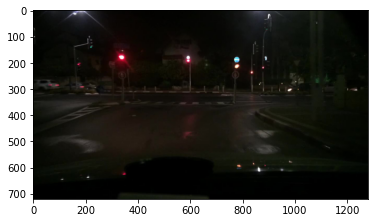

In [18]:
car_images = glob.glob('./images/100k/val/*.jpg')
i = 0
for car in car_images:
    img = mpimg.imread(car)
    print(car)
    plt.imshow(detect(img,[],[],7))
    i += 1

1


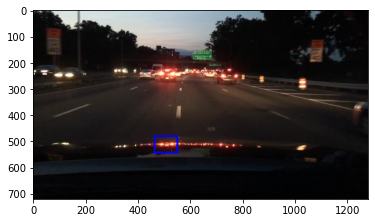

In [31]:
test_img = mpimg.imread("/Users/hqr/Desktop/FYP/images/100k/val/bd70577b-b4dd3097.jpg")
plt.imshow(detect(test_img,[],[],7))

## Detect the car and line in a video

In [31]:
video_in_folder  = os.path.join(root_folder, "data")
video_out_folder = os.path.join(root_folder, "results")
video_in_pattern = os.path.join(video_in_folder, "project_video.mp4")
video_in_fnames  = glob.glob(video_in_pattern)
video_out_fnames = [os.path.join(video_out_folder, os.path.basename(fname)) for fname in video_in_fnames]

only_use_videos = [0]  # Only use videos with indices specified here
use_subclip = False  # For testing

for i in range(len(video_in_fnames)):
    if only_use_videos and i not in only_use_videos:
        continue
    video_in_fname  = video_in_fnames[i]
    video_out_fname = video_out_fnames[i]
    
    clip = VideoFileClip(video_in_fname)
    if use_subclip:
        clip = clip.subclip(0, 3)
        
    LINE_HISTORY_LENGTH = 7
    left_lines = []
    right_lines = []

    
    processed_clip = clip.fl_image(
        lambda x: detect(
            x,
            left_lines, right_lines, LINE_HISTORY_LENGTH,
        )
    )
    %time processed_clip.write_videofile(video_out_fname, audio=False, verbose=True)
    
    clip.close()
    processed_clip.close()



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video /Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/results/project_video.mp4.
Moviepy - Writing video /Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/results/project_video.mp4



Moviepy - Done !
Moviepy - video ready /Users/hqr/Desktop/CarND-Advanced-Lane-Lines-master/results/project_video.mp4
CPU times: user 1h 46min 18s, sys: 10min 50s, total: 1h 57min 8s
Wall time: 46min 8s
